In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score
from sklearn.preprocessing import StandardScaler

### Load Dataset

In [2]:
train=pd.read_csv('train_BRCpofr.csv')
test=pd.read_csv('test_koRSKBP.csv')

###  Method for lower/Upper limit

In [3]:
lower_limit = train["cltv"].mean() - (3 * train["cltv"].std())
upper_limit = train["cltv"].mean() + (3 * train["cltv"].std())

print(f"Lower limit = {lower_limit}")
print(f"Upper limit = {upper_limit}")

Lower limit = -173888.61540204514
Upper limit = 369794.27335801435


## Capping Outliers

<AxesSubplot: ylabel='cltv'>

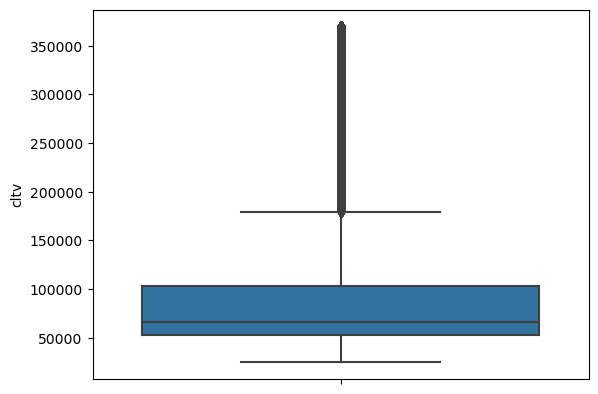

In [4]:
train["cltv"] = np.where(train["cltv"]> upper_limit, upper_limit,
                        np.where(train["cltv"]< lower_limit, lower_limit,
                        train["cltv"]))

sns.boxplot( y="cltv", data=train)

## Creating some features

In [5]:
train['gen_area']=np.where((train['gender']=='Male') & (train['area']=='Urban'),1,0)
train['quali_area']=np.where(((train['qualification']=='Bachelor') | (train['qualification']=='High School')) & (train['area']=='Urban'),1,0)
train['vint_area']=np.where(((train['vintage']==4) | (train['vintage']==5) | (train['vintage']==6) | (train['vintage']==7) | (train['vintage']==8)) & (train['area']=='Urban'),1,0)
train['type_area']=np.where((train['type_of_policy']=='Platinum') & (train['area']=='Urban'),1,0)
train['incom_area']=np.where(((train['income']=='5L-10L') | (train['income']=='More than 10L')) & (train['area']=='Urban'),1,0)
train['policy_area']=np.where((train['policy']=='A') & (train['area']=='Urban'),1,0)
train['num_policy_area']=np.where((train['num_policies']=='More than 1') & (train['area']=='Urban'),1,0)

train['claim_amount_Bucket']=np.where((train['claim_amount']==0),'0',
                                      np.where((train['claim_amount']<=3000),'3K',
                                               np.where((train['claim_amount']<=5000),'5K',
                                                        np.where((train['claim_amount']<=7000),'7K',
                                                                 np.where((train['claim_amount']<=8000),'8K','8K+')))))
train['gender_Male']=np.where((train['gender']=='Male'),1,0)
train['area_Urban']=np.where((train['area']== 'Urban'),1,0)
train['num_policies_More than 1']=np.where((train['num_policies']=='More than 1'),1,0)
train['income_More than 10L']=np.where((train['income']=='More than 10L'),1,0)
train['Loyal_Customer']=np.where((train['vintage']>=4),1,0)

In [6]:
train = train.drop("id", axis=1)

In [7]:
# Create dummies of categorical variable

train = pd.get_dummies(train, columns=["gender",'area','qualification','income','num_policies','policy','type_of_policy','claim_amount_Bucket'])

In [8]:
# Select Features for model building

data=train[['cltv','marital_status','vintage','claim_amount','gender_Male','area_Urban','num_policies_More than 1','num_policy_area','income_More than 10L']]

In [9]:
len(data.columns)

13

In [10]:
# Seperate dependent and independent variables 

X = data.drop("cltv", axis=1)
y = data["cltv"]

# Scale the dependent variable

ss = StandardScaler()
X = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,train_size = .7)

# fit model in linear regression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [11]:
model.coef_

array([-2.67564790e+03,  9.27089565e+01,  8.45838138e+03,  5.55597675e+16,
       -5.55597675e+16, -1.73418288e+15,  1.73418288e+15,  4.58382377e+15,
       -4.58382377e+15,  1.11020118e+04,  2.14250090e+15, -2.14250090e+15])

In [12]:
# Evaluate the model with r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.17533593041615525


In [13]:
#check correlation of variables

correlation_mat = data.corr()
corr_pairs = correlation_mat.unstack()
print(corr_pairs)

cltv                  cltv                        1.000000
                      marital_status             -0.080482
                      vintage                     0.022344
                      claim_amount                0.187674
                      gender_Male                -0.003840
                                                    ...   
income_More than 10L  num_policies_More than 1   -0.022319
                      num_policies_More than 1   -0.022319
                      num_policy_area            -0.107125
                      income_More than 10L        1.000000
                      income_More than 10L        1.000000
Length: 169, dtype: float64


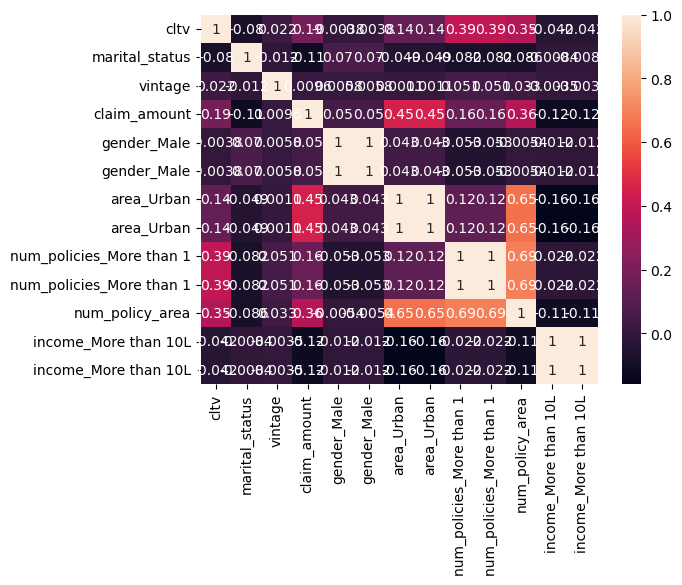

In [14]:
# check correlation of variables

correlation_mat = data.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

### Test Prediction

In [15]:
test_data = test.copy()

In [16]:
test_data['num_policy_area']=np.where((test_data['num_policies']=='More than 1') & (test_data['area']=='Urban'),1,0)
test_data['gender_Male']=np.where((test_data['gender']=='Male'),1,0)
test_data['area_Urban']=np.where((test_data['area']== 'Urban'),1,0)
test_data['num_policies_More than 1']=np.where((test_data['num_policies']=='More than 1'),1,0)
test_data['income_More than 10L']=np.where((test_data['income']=='More than 10L'),1,0)
test_data = pd.get_dummies(test_data, columns=["gender",'area','income','num_policies'])

In [17]:
test_final = test_data[['marital_status','vintage','claim_amount','gender_Male','area_Urban','num_policies_More than 1','num_policy_area','income_More than 10L']]

In [18]:
Test_pred = model.predict(test_final)

C:\Users\Nagendra\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [19]:
test['cltv'] = Test_pred

In [20]:
x=test[['id','cltv']]

In [21]:
x.to_csv('Prediction_Sheet.csv',index = False)

In [22]:
int(max(test['cltv']))

275311748